In [1]:
import limbo
from limbo.processing import CALGAIN
from limbo.fdmt import DM_delay 
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import os

# %matplotlib inline
%matplotlib notebook

# %load_ext memory_profiler

In [2]:
# pspec_file = os.environ['LIMBO_PSPEC_FILE']
# pspec_file = '/home/obs/data/save/Spectra_20230613095040.dat'
pspec_file = '/home/obs/data/save/Spectra_20230715184408.dat'
SUB = -6

# VOLT_DIR = os.environ.get('LIMBO_VOLT_DIR', None)
VOLT_DIR = '/mnt/data01'

VOLT_SAVE_DIR = os.environ.get('LIMBO_VOLT_SAVE_DIR', None)
VOLT_REMOVE_DIR = os.environ.get('LIMBO_VOLT_REMOVE_DIR', None)

VOLT_PREFIX = 'VoltageV2_'
f = os.path.basename(pspec_file[:SUB] + '*')
volt_files = sorted(glob.glob(os.path.join(VOLT_DIR, VOLT_PREFIX + f.split('_')[-1])))

PAD = 2000
RESAMP_FACTOR = 4
CH0, CH1 = 398, 398+1024
NSIG = 5.5

print('Processing candidate from', os.path.basename(pspec_file) + ':\n')
print('Processing Voltage Files:', [os.path.basename(file) for file in volt_files])

Processing candidate from Spectra_20230715184408.dat:

Processing Voltage Files: ['VoltageV2_20230715184403.dat', 'VoltageV2_20230715184404.dat', 'VoltageV2_20230715184405.dat', 'VoltageV2_20230715184406.dat', 'VoltageV2_20230715184407.dat', 'VoltageV2_20230715184408.dat']


In [3]:
vhdr = limbo.io.read_volt_header(volt_files[0])
vhdr

{'SWVer': '0.0.4',
 'fpg': 'limbo_500_m_2023-05-09_1203.fpg',
 'Time': 1689446643.467748,
 'AccLen': 1,
 'AdcCoarseGain': 4,
 'FFTShift': 2047,
 'DataSel': 1,
 'Scaling': 0,
 'Pol0EqCoeff': 59904,
 'Pol1EqCoeff': 59904,
 'SpecCoeff': 4,
 'AdcDelay0': 5,
 'AdcDelay1': 5,
 'AdcDelay2': 5,
 'AdcDelay3': 5,
 'AdcDelay4': 5,
 'AdcDelay5': 5,
 'AdcDelay6': 5,
 'AdcDelay7': 5,
 'RF_Lo_Hz': 1350000000,
 'Source': 'crab',
 'Target_RA_Deg': '05h34m31.95s',
 'Target_DEC_Deg': '+22d00m52.2s',
 'Pointing_AZ': 206.46,
 'Pointing_EL': 72.59,
 'Pointing_Updated': 1689446640.981721,
 'filename': '/mnt/data01/VoltageV2_20230715184403.dat',
 'sample_clock': 500000000.0,
 'freqs': array([1.35000000e+09, 1.35012207e+09, 1.35024414e+09, ...,
        1.59963379e+09, 1.59975586e+09, 1.59987793e+09]),
 'Time_created': 1689446643.551222,
 'filesize': 489392132,
 'data_start': 2052,
 'inttime': 8.192e-06,
 'nspec': 118784}

In [4]:
# Reprocess pspec file
hdr, data = limbo.io.read_file(pspec_file)

if hdr['Source'] == 'sgr1935':
    DM = 332.7
    k = (300, 400)
    MAX_DM = 300
    SUM_INT = 128
elif hdr['Source'] == 'crab':
    DM = 56.7
    k = (40, 60)
    MAX_DM = 30
    SUM_INT = 1
    
dmt = limbo.processing.process_data(hdr, data, maxdm=MAX_DM, 
                                    inpaint=True, ch0=CH0, ch1=CH1, do_dmt=True)

cal_data = dmt['diff'] * CALGAIN
delays = limbo.sim.DM_delay(DM, hdr['freqs']).astype('float32')
delays -= delays[-1]  # center lowest delay at t0
profile = limbo.utils.dedisperse(cal_data, DM, hdr['freqs'], hdr['inttime'], RESAMP_FACTOR)

freq_binned_profile = np.mean(profile[:, CH0:CH1].reshape(profile.shape[0], -1, 256), axis=-1)
avg_profile = np.mean(profile[:, CH0:CH1], axis=-1)
zscore = (avg_profile - np.mean(avg_profile)) / np.std(avg_profile)

tind_events = np.where((zscore > NSIG))[0]

_dts = np.linspace(hdr['times'][0], hdr['times'][-1], profile.shape[0], endpoint=False) # Unix time
# zeroed_dts = _dts - hdr['Time']

In [5]:
# Now process voltage files
vp = limbo.processing.ProcessVoltage(DM, volt_files, vhdr, hdr)

t_events = _dts[tind_events] # Unix time
data_real, data_imag, window, skip = vp.find_volt_window(t_events, PAD)
vdata = vp.sum_pols(data_real, data_imag)

vdmt = limbo.processing.process_data(vhdr, vdata, ch0=CH0, ch1=CH1, gsig=4, do_dmt=False, inpaint=False)
vcal_data = vdmt['diff'] * CALGAIN * np.sqrt(hdr['inttime'] / vhdr['inttime'])
vtimes = vp.get_volt_times()[skip:window+skip]

# SUM_INT = 128
vdata_summed = vp.sum_down(vcal_data, sum_int=SUM_INT)

vdelays = limbo.sim.DM_delay(DM, vhdr['freqs']).astype('float32')
vdelays -= vdelays[-1]  # center lowest delay at t0
vprofile = limbo.utils.dedisperse(vdata_summed, DM, vhdr['freqs'], SUM_INT * vhdr['inttime'], RESAMP_FACTOR)

In [6]:
vcal_data.shape, vprofile.shape

((8624, 1, 2048), (34496, 2048))

<IPython.core.display.Javascript object>


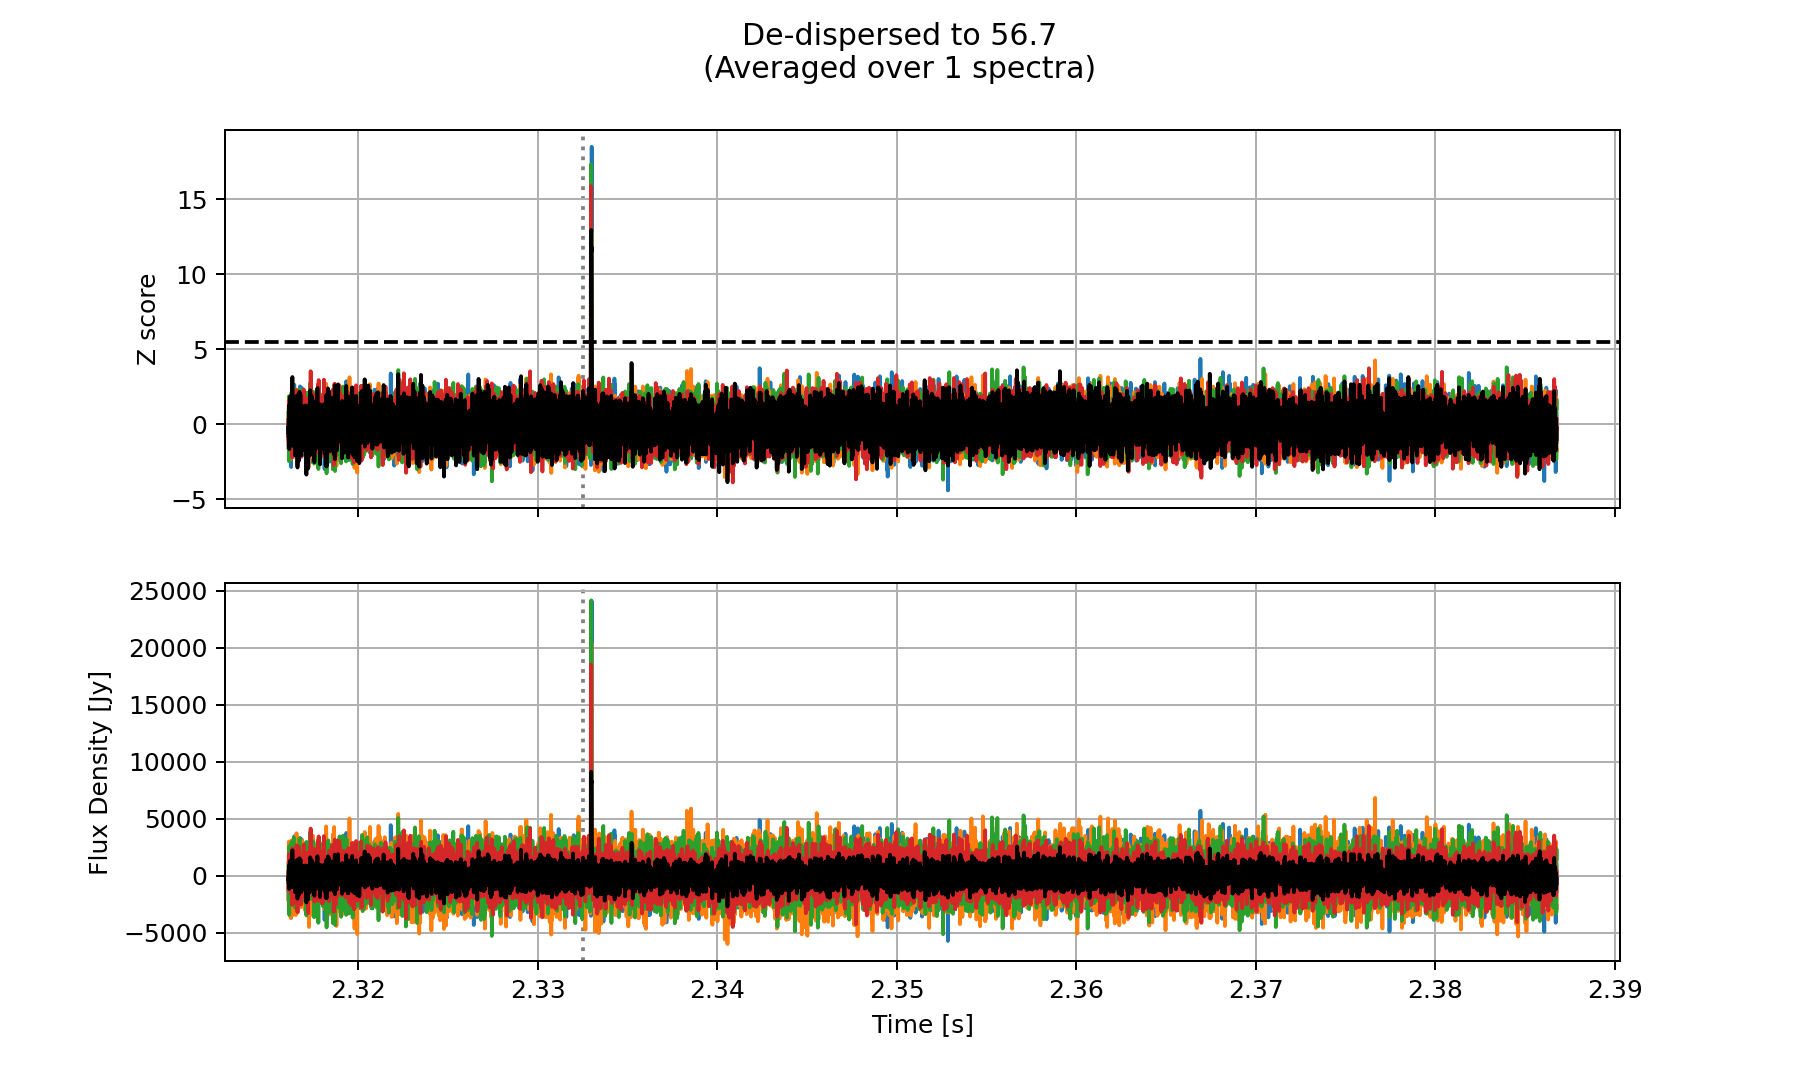

In [7]:
vts = np.linspace(vtimes[0], vtimes[-1], vprofile.shape[0], endpoint=False) - hdr['Time']
pulse_ind = int(vprofile.shape[0] * (PAD/vdata.shape[0])) # index of pulse
tpulse = vts[pulse_ind] # time of pulse

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=90)
freq_binned_vprofile = np.mean(vprofile[:, CH0:CH1].reshape(vprofile.shape[0], -1, 256), axis=-1)
avg_vprofile = np.mean(vprofile[:, CH0:CH1], axis=-1)
vzscore = (avg_vprofile - np.mean(avg_vprofile)) / np.std(avg_vprofile)
axes[0].plot(vts, (freq_binned_vprofile - np.mean(freq_binned_vprofile, axis=0, keepdims=True)) / np.std(freq_binned_vprofile, axis=0, keepdims=True))
axes[0].plot(vts, (avg_vprofile - np.mean(avg_vprofile)) / np.std(avg_vprofile), 'k')
axes[0].axhline(NSIG, color='k', ls='dashed')
axes[0].axvline(tpulse, color='grey', ls=':', zorder=0)
axes[1].plot(vts, freq_binned_vprofile)
axes[1].plot(vts, avg_vprofile, 'k')
axes[1].axvline(tpulse, color='grey', ls=':', zorder=0)
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel('Z score')
axes[0].grid()
axes[1].grid()
axes[1].set_ylabel('Flux Density [Jy]')
fig.suptitle(f'De-dispersed to {DM}\n(Averaged over {SUM_INT} spectra)')
plt.show()

In [8]:
recovered = False
events = np.where(vzscore > NSIG)[0]
if events.size > 0:
    print('Candidate FRB recovered.')
    zmax = np.max(vzscore[events])
    print(f'De-dispersed Z-score: {zmax:4.1f}')
    recovered = True
    
print(f'Recovered: {recovered}')

Candidate FRB recovered.
De-dispersed Z-score: 12.9
Recovered: True


In [13]:
if recovered:
    # SUM_INT = 1
    OVERSAMP = 1
    NTRIALS = 128
    snr_zscore, mDM = vp.snr_dedispersion(vdmt=vdmt, sum_int=SUM_INT, resamp_factor=OVERSAMP, 
                                          ch0=CH0, ch1=CH1, pmDM=2, ntrials=NTRIALS)
    print('-- De-Dispersed to maximize SNR --\nZ-score: {0:.3f}\nMeasured DM: {1:.3f}'.format(snr_zscore, mDM))

100%|█████████████████████████████████████████████████████████████| 512/512 [09:05<00:00,  1.06s/it]

-- De-Dispersed to maximize SNR --
Z-score: 31.949
Measured DM: 56.864


In [14]:
if recovered:
    snrprofile = limbo.utils.dedisperse(vdata_summed, mDM, vhdr['freqs'], SUM_INT * vhdr['inttime'])
    freq_binned_snrprofile = np.mean(snrprofile[:, CH0:CH1].reshape(snrprofile.shape[0], -1, 256), axis=-1)
    avg_snrprofile = np.mean(snrprofile[:, CH0:CH1], axis=-1)
    snr_zscore = (avg_snrprofile - np.mean(avg_snrprofile)) / np.std(avg_snrprofile)

<IPython.core.display.Javascript object>


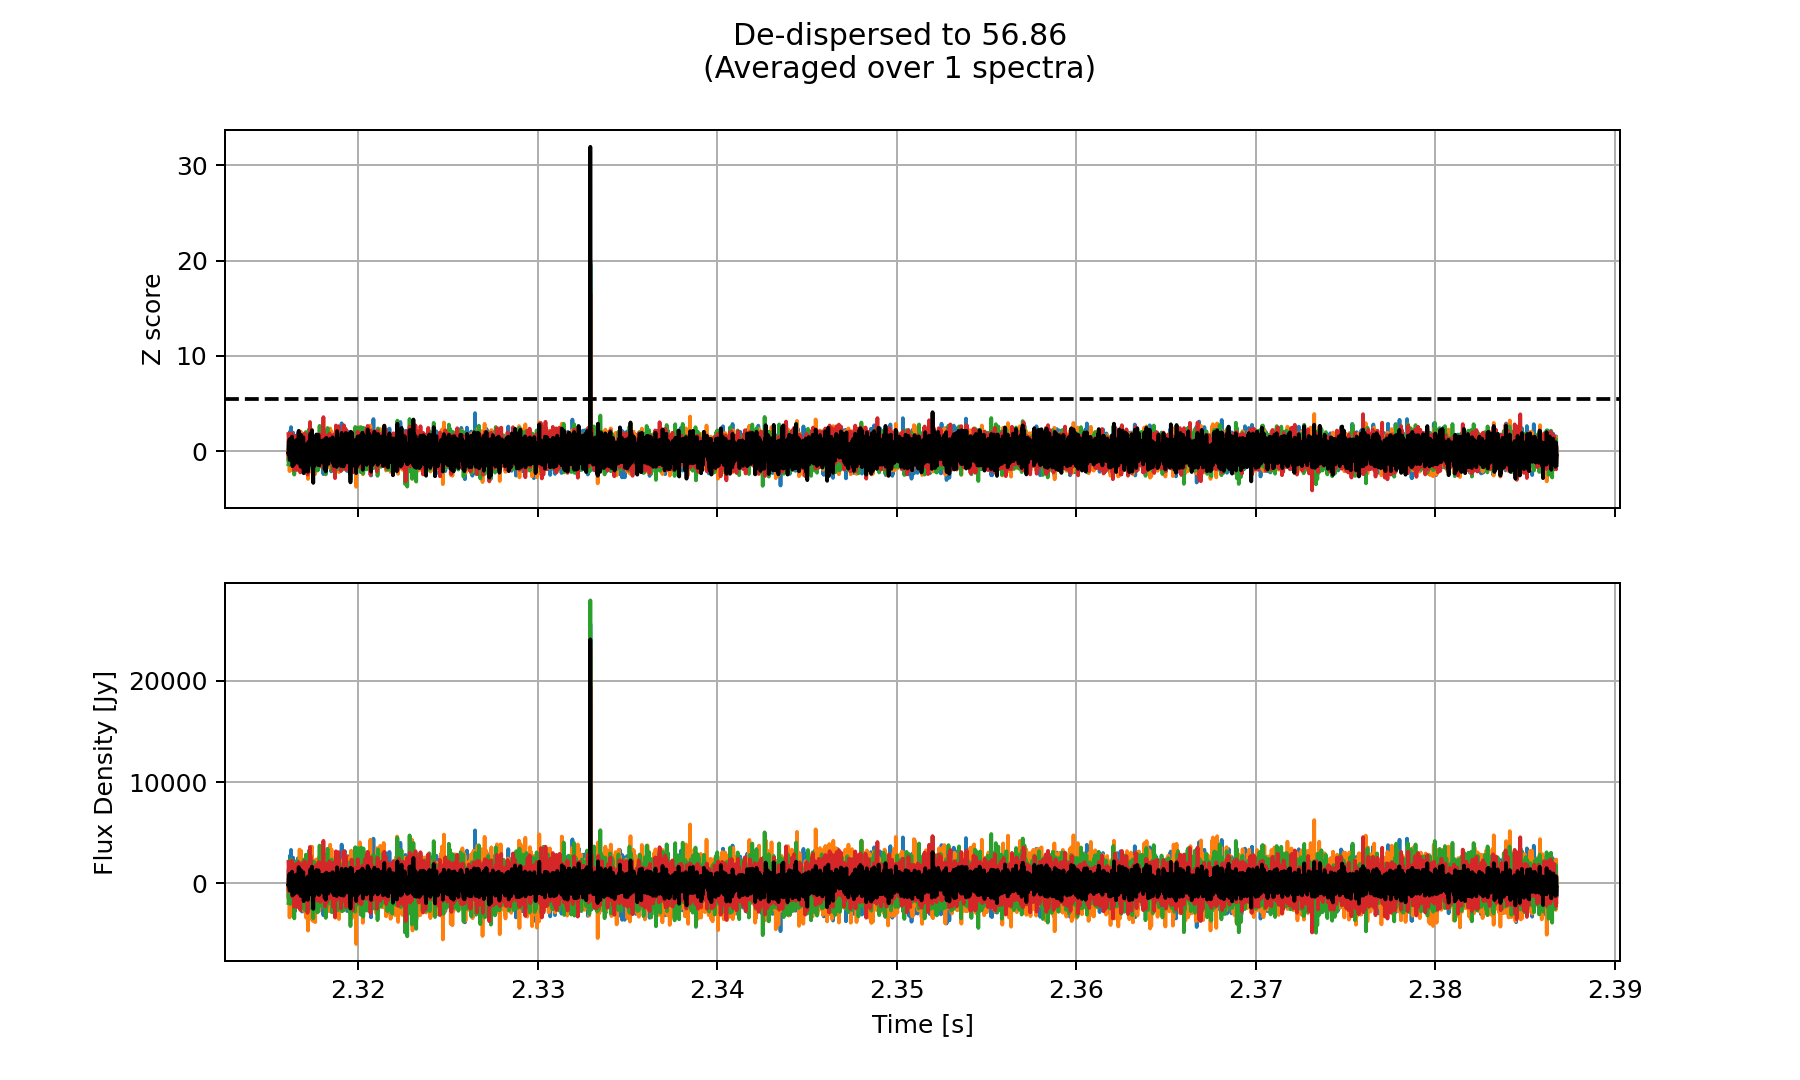

In [15]:
if recovered:
    vts = np.linspace(vtimes[0], vtimes[-1], snrprofile.shape[0], endpoint=False) - hdr['Time']

    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=90)
    axes[0].plot(vts, (freq_binned_snrprofile - np.mean(freq_binned_snrprofile, axis=0, keepdims=True)) / np.std(freq_binned_snrprofile, axis=0, keepdims=True))
    axes[0].plot(vts, (avg_snrprofile - np.mean(avg_snrprofile)) / np.std(avg_snrprofile), 'k')
    axes[0].axhline(NSIG, color='k', ls='dashed')
    axes[1].plot(vts, freq_binned_snrprofile)
    axes[1].plot(vts, avg_snrprofile, 'k')
    axes[1].set_xlabel('Time [s]')
    axes[0].set_ylabel('Z score')
    axes[0].grid()
    axes[1].grid()
    axes[1].set_ylabel('Flux Density [Jy]')
    fig.suptitle('De-dispersed to {0:.2f}\n(Averaged over {1} spectra)'.format(mDM, SUM_INT))
    plt.show()

<IPython.core.display.Javascript object>


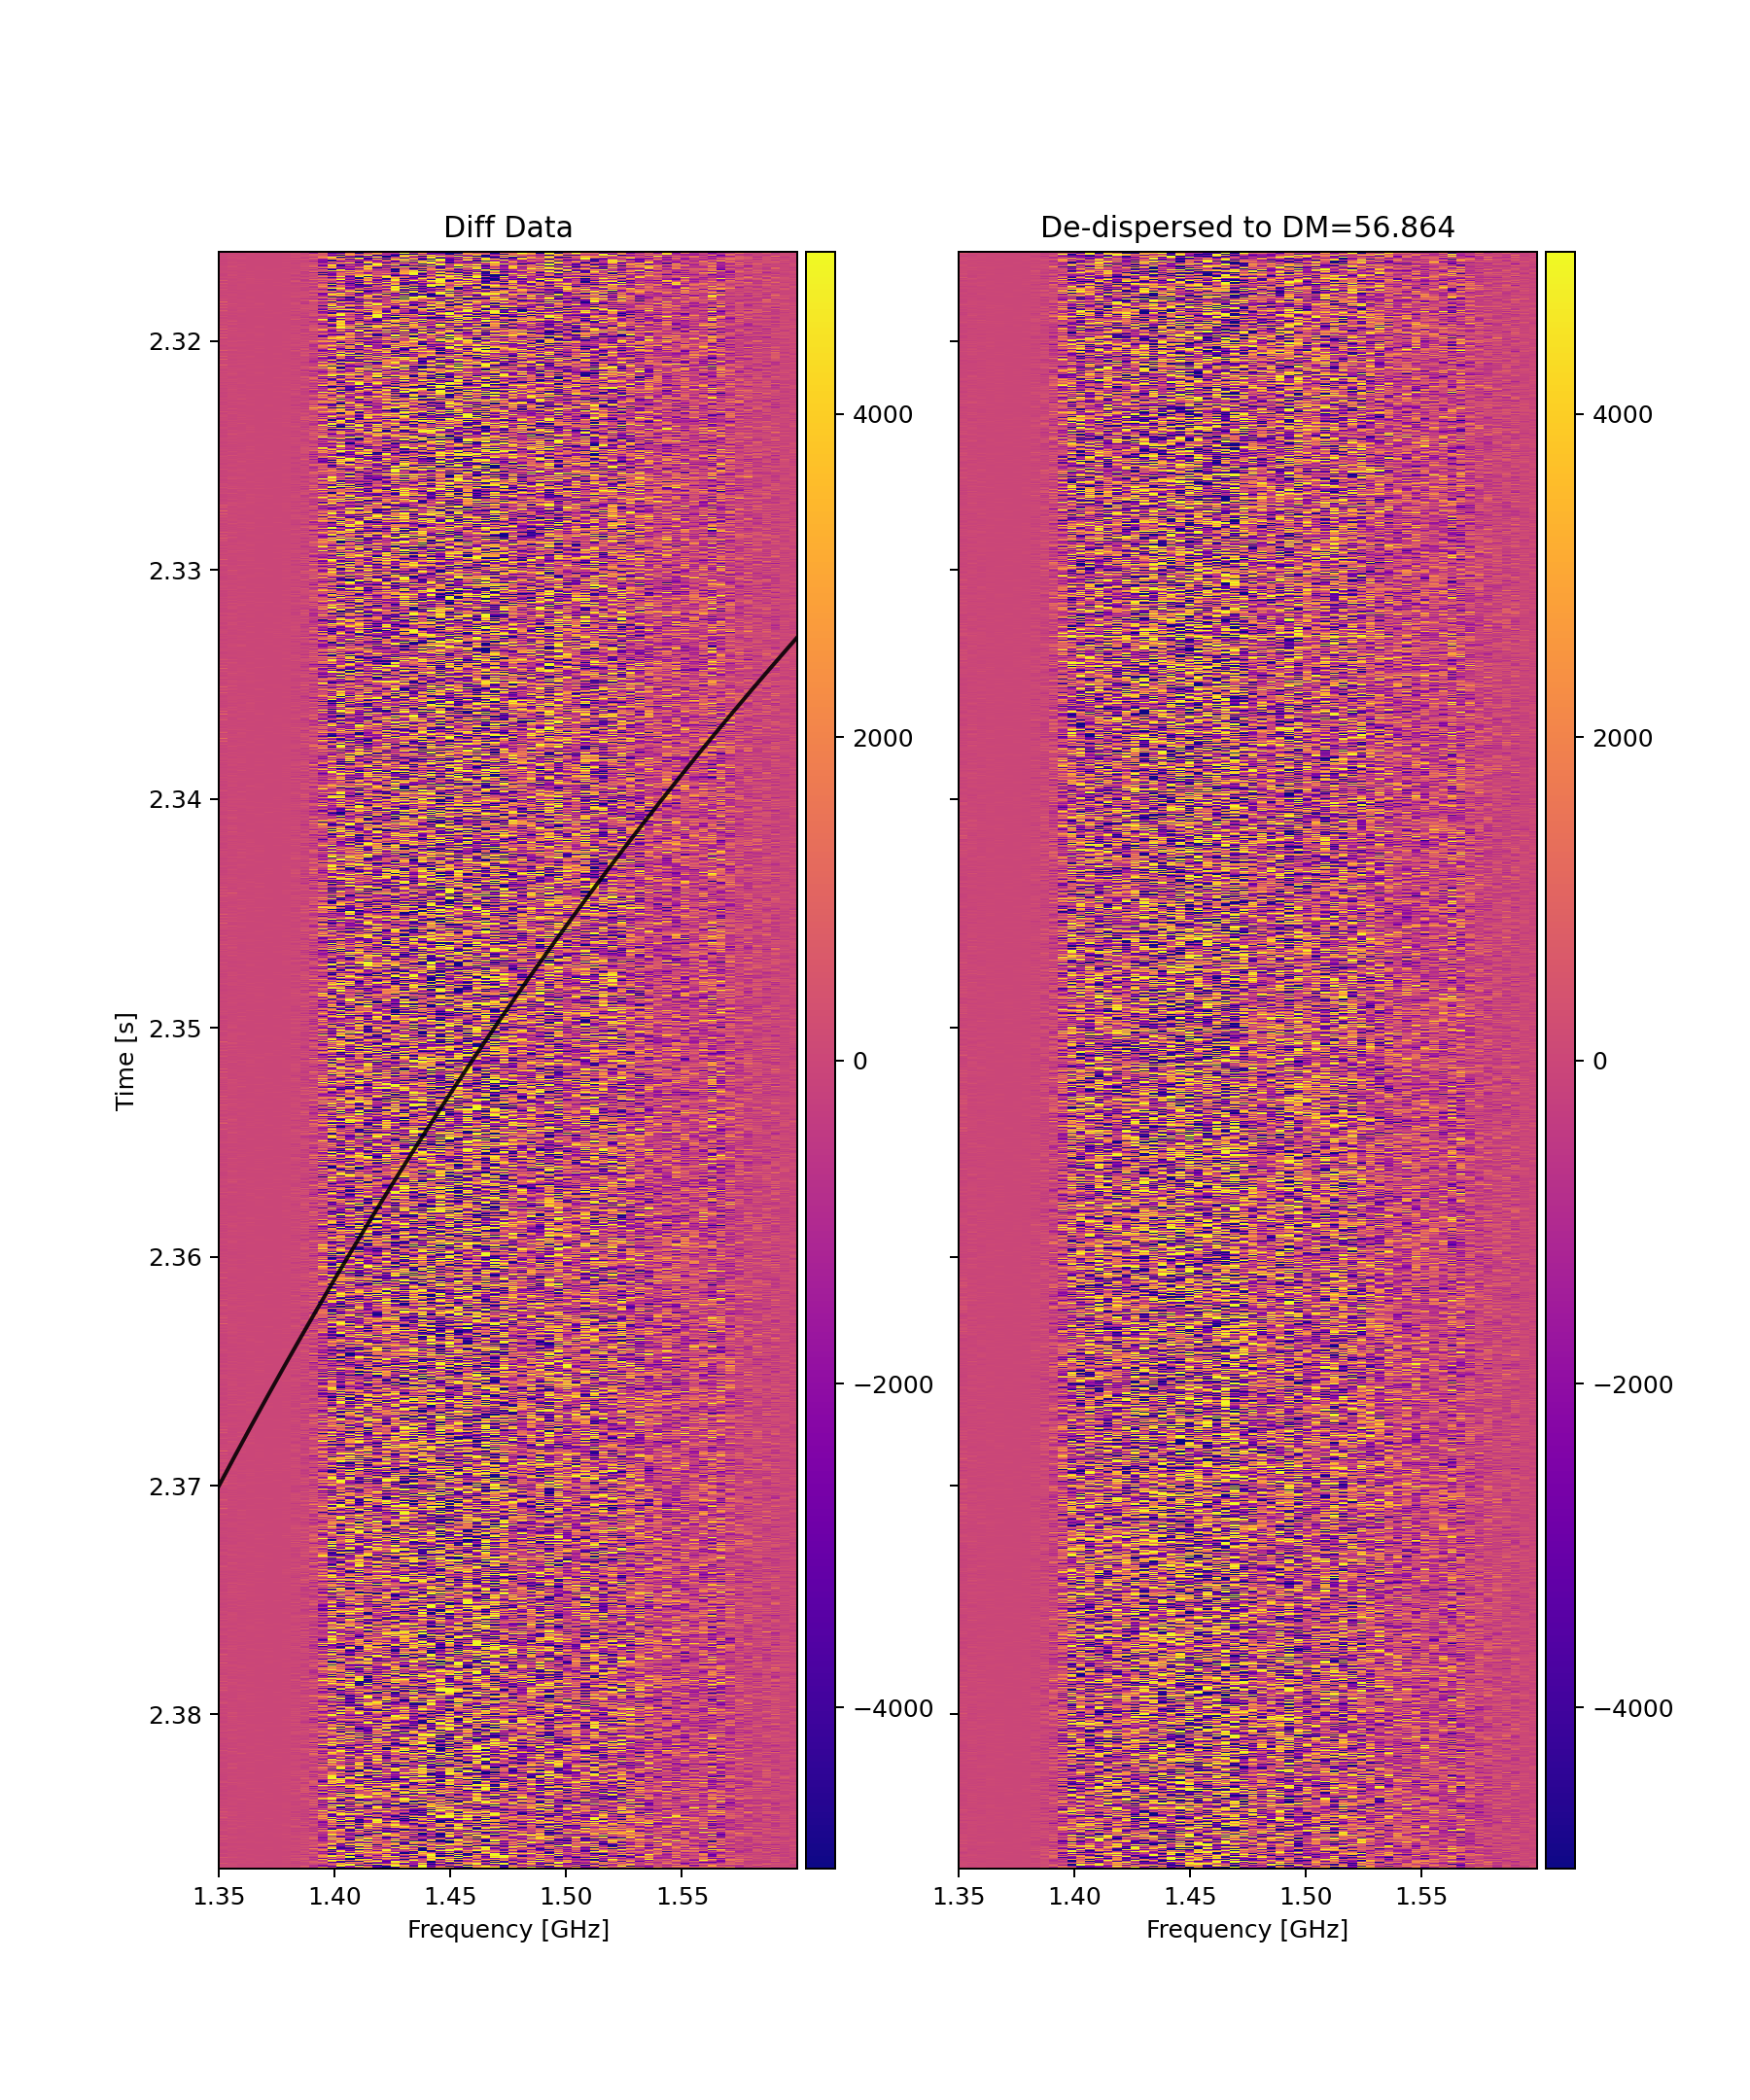

In [16]:
if recovered:
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)
    if hdr['Source'] == 'crab':
        min_scale, max_scale = -5000, 5000
    else:
        min_scale, max_scale = -500, 500
    vd = vdata_summed.copy()
    vd.shape = (vd.shape[0], -1, 32)
    vprof = snrprofile.copy()
    vprof.shape = (vprof.shape[0], -1, 32)
    vd = np.mean(vd, axis=-1)
    vprof = np.mean(vprof, axis=-1)
    im0 = axes[0].imshow(vd, extent=(vhdr['freqs'][0] / 1e9, vhdr['freqs'][-1] / 1e9, vts[-1], vts[0]),
                   cmap='plasma', vmax=max_scale, vmin=min_scale, interpolation='nearest', aspect='auto')
    im1 = axes[1].imshow(vprof, extent=(vhdr['freqs'][0] / 1e9, vhdr['freqs'][-1] / 1e9, vts[-1], vts[0]),
                   cmap='plasma', vmax=max_scale, vmin=min_scale, interpolation='nearest', aspect='auto')
    for event in np.argwhere(snr_zscore > NSIG):
        t = vts[event]
        axes[0].plot(vhdr['freqs'] / 1e9, t + vdelays, 'k', alpha=0.5)
    axes[0].set_xlabel('Frequency [GHz]')
    axes[1].set_xlabel('Frequency [GHz]')
    axes[0].set_title(f'Diff Data')
    axes[1].set_title(f'De-dispersed to DM={mDM:0.3f}')
    axes[0].set_ylabel('Time [s]')
    cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im0, cax=cax)
    cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im1, cax=cax)